In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install chainer
import chainer
print(chainer.__version__)

import os
from PIL import Image
import chainer
import shutil



def train_save(data, index, num):
    img = Image.new("L", (28, 28))
    pix = img.load()
    for i in range(28):
        for j in range(28):
            pix[i, j] = int(data[i+j*28]*256)
    img2 = img.resize((280, 280))
    filename ="based_image_data/" +str(num) + "/train" + "{0:04d}".format(index) + ".png"
    img2.save(filename)


def save(data, index, num):
    img = Image.new("L", (28, 28))
    pix = img.load()
    for i in range(28):
        for j in range(28):
            pix[i, j] = int(data[i+j*28]*256)
    img2 = img.resize((280, 280))
    filename = "test_image/"+str(num) + "/test" + "{0:04d}".format(index) + ".png"
    img2.save(filename)

def main():
    train, test = chainer.datasets.get_mnist()
    shutil.rmtree("based_image_data",ignore_errors=True)
    shutil.rmtree("test_image",ignore_errors=True)
    for i in range(10):
        dirname ="based_image_data/" +str(i)
        if os.path.isdir(dirname) is False:
            os.makedirs(dirname)
    for i in range(20000):
        train_save(train[i][0], i, train[i][1])


    for i in range(10):
        dirname ="test_image/"+ str(i)
        if os.path.isdir(dirname) is False:
            os.makedirs(dirname)
    for i in range(7000):
        save(test[i][0], i, test[i][1])

if __name__ == '__main__':
    main()

Mounted at /content/drive
     |████████████████████████████████| 1.0 MB 3.7 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=3ec7fe95700a3971f1bb7c0a07ad813cecc37b771fcbad08bf46f94dec0bbbcd
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainer


/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


7.8.1


In [ ]:
import tensorflow as tf

# ArcFaceの前半部分
class ArcFaceLayer0(tf.keras.layers.Layer) :
    def __init__(self, num_outputs, kernel_regularizer = None, **kargs) :
        super(ArcFaceLayer0, self).__init__(**kargs)
        self.num_outputs = num_outputs
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape) :
        weight_shape = (input_shape[-1] , self.num_outputs)
        self.kernel = self.add_weight(
            name='kernel',
            shape = weight_shape,
            initializer = tf.keras.initializers.TruncatedNormal(),
            regularizer = self.kernel_regularizer,
            trainable = True
            )
        super(ArcFaceLayer0, self).build(input_shape)

    def call(self, input) :
        n_input = tf.math.l2_normalize(input, axis = 1)               # inputのL2正規化
        n_kernel = tf.math.l2_normalize(self.kernel, axis = 0)        # 重みのL2正規化
        return tf.matmul(n_input, n_kernel)      # W.Txの内積

# 損失関数側に実装したArcFace
class ArcFaceLoss(tf.keras.losses.Loss) :
    # m:マージン
    # s:倍率
    # loss_func:本来の損失関数 tf.keras.losses.CategoricalCrossentropy(from_logits = True)など
    def __init__(self, loss_func, m = 0.5, s = 30, name = "arcface_loss", **kwargs) :
        self.loss_func = loss_func
        self.margin = m
        self.s = s
        self.enable = True
        super(ArcFaceLoss, self).__init__(name = name, **kwargs)

    def call(self, y_true, y_pred):
        # y_predは cos(θ)
        # 加法定理のためにsin(θ)を計算する
        sine = tf.keras.backend.sqrt(1.0 - tf.keras.backend.square(y_pred))
        phi = y_pred * self.cos_m - sine * self.sin_m       # cos(θ+m)の加法定理
        phi = tf.where(y_pred > 0, phi, y_pred)             # あさってを向いているときはそのまま

        # 正解クラス:cos(θ+m) 他のクラス:cosθ 
        logits = (y_true * phi) + ((1.0 - y_true) * y_pred)

        # 本来の損失関数を呼び出す
        return self.loss_func(y_true, logits * self.s)

# ArcFace用の評価関数
class ArcFaceAccuracy(tf.keras.metrics.Mean) :
    def __init__(self, metrics_func, s = 30, name = "arcface_accuracy", dtype = None) :
        self.metrics_func = metrics_func
        self.s = s
        super(ArcFaceAccuracy, self).__init__(name, dtype)

    def update_state(self, y_true, y_pred, sample_weight = None) :
        output = tf.nn.softmax(y_pred * self.s)
        matches = self.metrics_func(y_true, output)

        return super(ArcFaceAccuracy, self).update_state(matches, sample_weight = sample_weight) 
# model構築の準備
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input,Dropout,Activation
import tensorflow.keras.applications.mobilenet_v2
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import CSVLogger,EarlyStopping
import numpy as np
from keras import backend as K

from tensorflow.keras.layers import Dense, Dropout, Input
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import os
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf


class Arcfacelayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, s=30, m=0.50, easy_magin=False):
        self.output_dim = output_dim
        self.s = s
        self.m = m
        self.easy_magin = easy_magin
        super(Arcfacelayer, self).__init__()
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Arcfacelayer, self).build(input_shape)
        
    def call(self, x):
        y = x[1]
        x_normalize = tf.math.l2_normalize(x[0]) #|x = x'/ ||x'||2
        k_normalize = tf.math.l2_normalize(self.kernel) # Wj = Wj' / ||Wj'||2
        
        cos_m = K.cos(self.m)
        sin_m = K.sin(self.m)
        th = K.cos(np.pi - self.m)
        mm = K.sin(np.pi - self.m) * self.m
        
        cosine = K.dot(x_normalize, k_normalize) # W.Txの内積
        
        sine = K.sqrt(1.0 - K.square(cosine))
        phi = cosine * cos_m - sine * sin_m
        
        if self.easy_magin:
            phi = tf.where(cosine > 0, phi, cosine) 
            
        else:
            phi = tf.where(cosine > th, phi, cosine - mm) 
        
        output = (y * phi) + ((1.0 - y) * cosine) # true cos(θ+m), False cos(θ)
        output *= self.s
        
        return output
    
    def compute_output_shape(self, input_shape):
        
        return (input_shape[0][0], self.output_dim)
        #return self.output_dim



In [ ]:
import shutil
import os


shutil.rmtree("Unregistered_image",ignore_errors=True)
os.makedirs("Unregistered_image")
shutil.copytree("/content/based_image_data/3","Unregistered_image/3")
shutil.rmtree("/content/based_image_data/3")
shutil.copytree("/content/based_image_data/6","Unregistered_image/6")
shutil.rmtree("/content/based_image_data/6")

In [ ]:
import os
import shutil
import random
import glob
from natsort import natsorted
import sys
sys.path.append("/content/drive/MyDrive/functions/")

import functions as func

def gazo_sprit_many_class(original_dir, base_dir, train_size):
    '''
    画像データをトレインデータとテストデータに分割します。フォルダもなければ作成します。
    parameter
    ------------
    original_dir: strのリスト
      オリジナルデータフォルダのパスのリスト その下に各クラスのフォルダがある
    base_dir: str
      分けたデータを格納するフォルダのパス　そ子にフォルダが作られます
    train_size: float
      トレインデータの割合
    '''
    
    label=natsorted(func.get_labels())
    print(label)
    shutil.rmtree("train_image",ignore_errors=True)
    shutil.rmtree("val_image",ignore_errors=True)
    for i in label:
      os.makedirs("train_image/"+str(i))
      os.makedirs("val_image/"+str(i))
    train_size=100
    val_size=20
    char_dir=glob.glob("/content/based_image_data/*")
    char_dir=natsorted(char_dir)
    print(char_dir)
    for i in char_dir:
      file_path_list=glob.glob(i+"/*")

      if train_size+val_size>len(file_path_list):
        print("ERROR : 分割必要枚数より少ないです")

      train=file_path_list[:train_size]
      val=file_path_list[train_size:train_size+val_size]
   
      for j in train:
        b=j.split("/")
        a="/content/train_image/"+b[-2]+"/"+b[-1]
        shutil.copyfile(j,a)
      for j in val:
        b=j.split("/")
        a="/content/val_image/"+b[-2]+"/"+b[-1]
        shutil.copyfile(j,a)
    print("分割終了")


def main():
    shutil.rmtree("/content/zidolegi_data",ignore_errors=True)
    original_dir = "/content/image_data"
    base_dir = "zidolegi_data"
    train_size = 0.8
    gazo_sprit_many_class(original_dir,base_dir,train_size)

if __name__ == "__main__":
    main()

['0', '1', '2', '4', '5', '7', '8', '9']
['/content/based_image_data/0', '/content/based_image_data/1', '/content/based_image_data/2', '/content/based_image_data/4', '/content/based_image_data/5', '/content/based_image_data/7', '/content/based_image_data/8', '/content/based_image_data/9']
分割終了


In [ ]:

#モデルの実装

import glob


def create_mobilenet_with_arcface(n_categories, file_path=None):
    base_model=tensorflow.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3),
                       weights='imagenet',
                       include_top=False)
    
    
    #add new layers instead of FC networks
    x = base_model.output
    n_categories=len(glob.glob("train_image/*"))
    yinput = Input(shape=(n_categories,))
    # stock hidden model
    hidden = GlobalAveragePooling2D()(x)
    # stock Feature extraction
    #x = Dropout(0.5)(hidden)
    x = Arcfacelayer(10, 30, 0.05)([hidden,yinput])
    #x = Dense(1024,activation='relu')(x)
    prediction = Activation('softmax')(x)
    model = Model(inputs=[base_model.input,yinput],outputs=prediction)
    
    if file_path:
        model.load_weights(file_path)
        print('weightは{}'.format(file_path))
    
    return model

class train_Generator_xandy(object): # rule1
    def __init__(self,model=None):
        datagen = ImageDataGenerator(
                             vertical_flip = False,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             rescale=1.0/255.,
                             zoom_range=0.2,  
                             fill_mode = "constant", 
                             cval=0)
        train_generator=datagen.flow_from_directory(
          train_dir,
          target_size=(224,224),
          batch_size=25,
          class_mode='categorical',
          shuffle=True)
        self.model=model
        self.gene = train_generator
        
    def __iter__(self):
    # __next__()はselfが実装してるのでそのままselfを返す
        return self
    
    def __next__(self): 
        X, Y = self.gene.next()
        return [X,Y], Y
    def __bottlenext__(self):
        X,Y=self.gene.next()
        X=self.model.predict(X)
        return [X,Y],Y

class val_Generator_xandy(object):
    def __init__(self,model=None):
        validation_datagen=ImageDataGenerator(rescale=1.0/255.)
        
        validation_generator=validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(224,224),
            batch_size=25,
            class_mode='categorical',
            shuffle=True)
            
        self.gene = validation_generator
        self.model=model

    def __iter__(self):
    # __next__()はselfが実装してるのでそのままselfを返す
        return self
            
    def __next__(self): 
        X, Y = self.gene.next()
        return [X,Y], Y
    
    def __bottlenext__(self):
        X,Y=self.gene.next()
        X=self.model.predict(X)
        return [X,Y],Y

def create_VGG16_fearure():
  model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
  return model


bottle_model=create_VGG16_fearure()
train_dir = '/content/train_image'
validation_dir = '/content/val_image'
train_gene = train_Generator_xandy(bottle_model)
val_gane = val_Generator_xandy(bottle_model)

58900480/58889256 [==============================] - 2s 0us/step
Found 800 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [ ]:
import glob
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization,GlobalAveragePooling2D


def create_VGG16_fearure():
  model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
  return model

def create_mobilenet_with_arcface(n_categories, file_path=None):
    base_model=tensorflow.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3),
                       weights='imagenet',
                       include_top=False)
    #add new layers instead of FC networks
    x = base_model.output
    n_categories=len(glob.glob("train_image/*"))
    yinput = Input(shape=(n_categories,))
    # stock hidden model
    hidden = GlobalAveragePooling2D()(x)
    # stock Feature extraction
    #x = Dropout(0.5)(hidden)
    x = Arcfacelayer(n_categories, 30, 0.05)([hidden,yinput])
    #x = Dense(1024,activation='relu')(x)
    prediction = Activation('softmax')(x)
    model = Model(inputs=[base_model.input,yinput],outputs=prediction)
    
    if file_path:
        model.load_weights(file_path)
        print('weightは{}'.format(file_path))
    
    return model

def create_vgg16_with_arcface(n_categories, file_path=None):
    base_model=tensorflow.keras.applications.vgg16.VGG16(input_shape=(224,224,3),
                       weights='imagenet',
                       include_top=False)
    
    
    #add new layers instead of FC networks
    x = base_model.output
    n_categories=len(glob.glob("train_image/*"))
    yinput = Input(shape=(n_categories,))
    # stock hidden model
    hidden = GlobalAveragePooling2D()(x)
    # stock Feature extraction
    #x = Dropout(0.5)(hidden)
    x = Arcfacelayer(n_categories, 30, 0.05)([hidden,yinput])
    #x = Dense(1024,activation='relu')(x)
    prediction = Activation('softmax')(x)
    model = Model(inputs=[base_model.input,yinput],outputs=prediction)
    
    if file_path:
        model.load_weights(file_path)
        print('weightは{}'.format(file_path))
    
    return model

def create_trans_model_ArcFace(n_categories,file_path=None):
    base_model=tensorflow.keras.applications.vgg16.VGG16(input_shape=(224,224,3),
                       weights='imagenet',
                       include_top=False)
    
    
    #add new layers instead of FC networks
    n_categories=len(glob.glob("train_image/*"))
  
    yinput = Input(shape=(n_categories,))


    # stock hidden model
    x=GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)    
    # stock Feature extraction
    #x = Dropout(0.5)(hidden)
    x = Arcfacelayer(n_categories, 30, 0.05)([x,yinput])
    #x = Dense(1024,activation='relu')(x)
    prediction = Activation('softmax')(x)
    model = Model(inputs=[base_model.input,yinput],outputs=prediction)
    
    if file_path:
        model.load_weights(file_path)
        print('weightは{}'.format(file_path))
    
    return model

n_categories=len(glob.glob("train_image/*"))
model=create_vgg16_with_arcface(n_categories)
#model=create_mobilenet_with_arcface(n_categories)
#model=create_trans_model_ArcFace(n_categories)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

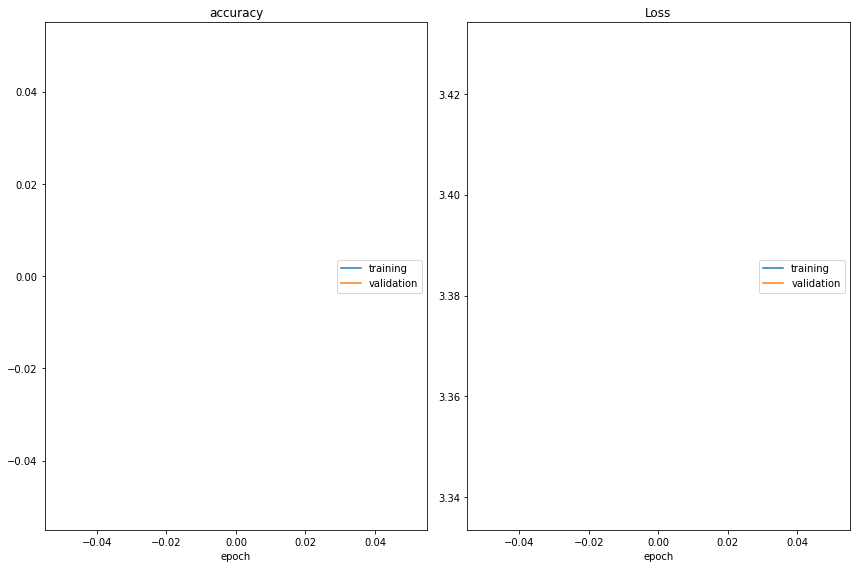

accuracy
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    3.430, max:    3.430, cur:    3.430)
	validation       	 (min:    3.338, max:    3.338, cur:    3.338)
epoch0 : save weights
80/80 [==============================] - 57s 485ms/step - loss: 3.4296 - accuracy: 0.0000e+00 - val_loss: 3.3381 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05

Epoch 00002: CosineAnnealingScheduler setting learning rate to 9.999726120980735e-06.
Epoch 2/300
36/80 [============>.................] - ETA: 16s - loss: 3.2978 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
# layerを徐々に解凍しながら学習する
!pip install livelossplot
from keras import callbacks
from livelossplot import PlotLossesKeras
import argparse
from keras.callbacks import Callback
import math

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--scheduler', default='CosineAnnealing',
                        choices=['CosineAnnealing', 'None'],
                        help='scheduler: ' +
                            ' | '.join(['CosineAnnealing', 'None']) +
                            ' (default: CosineAnnealing)')
    parser.add_argument('--lr', '--learning-rate', default=1e-5, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--min-lr', default=1e-6, type=float,
                        help='minimum learning rate')
    parser.add_argument('--epochs', default=150, type=int)
    args_list=['--epochs',"300","--min-lr","1e-8","--lr","1e-5"]
    args = parser.parse_args(args=args_list)
    return args
class KeepModelDirectory(Callback):
  def __init__(self,dir_path,each_epoch=20):
    self.dir_path=dir_path
    self.each_epoch=each_epoch
  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.each_epoch == 0:
      print("epoch{} : save weights".format(epoch))
      shutil.rmtree(self.dir_path,ignore_errors=True)
      shutil.copytree("/content/models",self.dir_path)
class CosineAnnealingScheduler(Callback):
    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
n_categories=len(glob.glob("based_image_data/*"))
labels=func.get_labels()


#model=create_trans_model_ArcFace(n_categories)
model=create_vgg16_with_arcface(n_categories)
#model=create_mobilenet_with_arcface(n_categories)
#model = create_mobilenet_with_arcface(n_categories)


shutil.rmtree("models",ignore_errors=True)
os.makedirs("models")
maenosavepath = None
with open('models/labels.txt', 'w') as f:
  for d in labels:
    f.write("%s\n" % d)
with open('models/train_size.txt', 'w') as f:
  f.write(str(len(glob.glob("/content/train_image/*/*"))/len(glob.glob("/content/train_image/*"))))
with open('models/val_size.txt', 'w') as f:
  f.write(str(len(glob.glob("/content/val_image/*/*"))/len(glob.glob("/content/val_image/*"))))
if not os.path.exists("/content/drive/MyDrive/ArcFace_models"):
  os.makedirs("/content/drive/MyDrive/ArcFace_models")
with open("models/data.txt",'w') as f:
  if os.path.exists("/content/based_image_data/0"):
    f.write("mnistデータ")
  else:
    f.write("自前データ")

target_layer="block5_conv1"
with open('models/target.txt', 'w') as f:
  f.write(str(target_layer)+" "+str(model.layers.index(model.get_layer(target_layer))))
touketulayerlists = [model.layers.index(model.get_layer(target_layer)),]

for touketu in touketulayerlists:
    dir_num=1
    save_dir=""
    modelsavepath="/content/models/model.weights"
    while True:
      if os.path.exists("/content/drive/MyDrive/ArcFace_models/No."+str(dir_num)):
        dir_num=dir_num+1
        continue
      save_dir="/content/drive/MyDrive/ArcFace_models/No."+str(dir_num)
      break
    print('touketu{}'.format(touketu))
    #凍結
    for layer in model.layers[:touketu]:
        layer.trainable=False
    for layer in model.layers[touketu:]:
        layer.trainable=True
    model.summary()
    #learning_rate=0.00001
    learning_rate=0.00001
    with open('models/lr.txt', 'w') as f:
      f.write(str(learning_rate))
    args=parse_args()
    with open('/content/models/args.txt' , 'w') as f:
        for arg in vars(args):
            print('%s: %s' %(arg, getattr(args, arg)), file=f)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    csv_logger = CSVLogger('models/training.'+str(touketu)+'.csv')
    callbacks_list = [
        PlotLossesKeras(),
        csv_logger,
        #バリデーションlossが改善したらモデルをsave
        callbacks.ModelCheckpoint(
        filepath=modelsavepath,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True),
        KeepModelDirectory(save_dir)
        #バリデーションlossが改善しなくなったら学習率を変更する
    ]

    EPOCHS=args.epochs
    callbacks_list.append(CosineAnnealingScheduler(T_max=args.epochs, eta_max=args.lr, eta_min=args.min_lr, verbose=1))
    model.fit(train_gene, steps_per_epoch=80, epochs=EPOCHS, validation_steps=20, validation_data=val_gane, callbacks=callbacks_list)
    shutil.rmtree(save_dir,ignore_errors=True)
    shutil.copytree("models",save_dir)
    shutil.rmtree("models",ignore_errors=True)

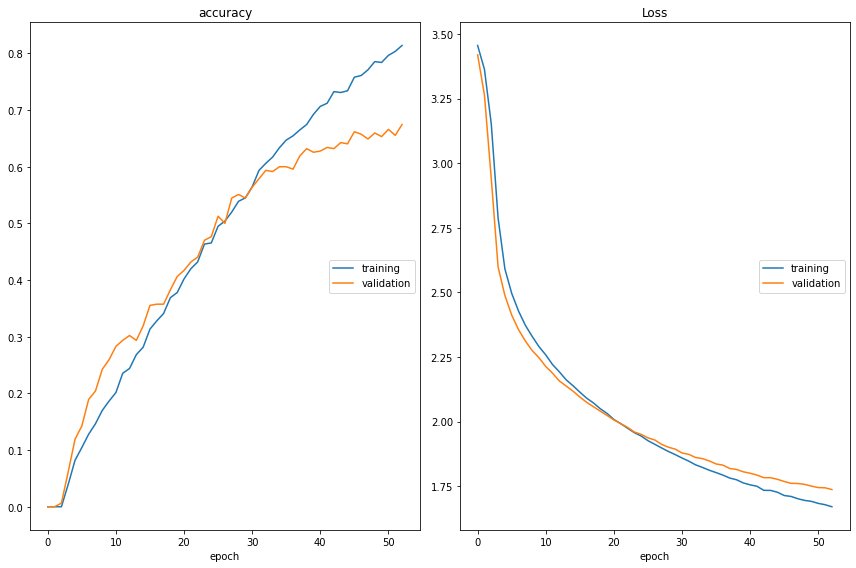

accuracy
	training         	 (min:    0.000, max:    0.814, cur:    0.814)
	validation       	 (min:    0.000, max:    0.674, cur:    0.674)
Loss
	training         	 (min:    1.670, max:    3.456, cur:    1.670)
	validation       	 (min:    1.737, max:    3.420, cur:    1.737)
80/80 [==============================] - 32s 402ms/step - loss: 1.6704 - accuracy: 0.8140 - val_loss: 1.7370 - val_accuracy: 0.6745 - lr: 9.4657e-06

Epoch 00054: CosineAnnealingScheduler setting learning rate to 9.445355465215485e-06.
Epoch 54/350
66/80 [=======================>......] - ETA: 4s - loss: 1.6701 - accuracy: 0.8048

In [ ]:
# layerを徐々に解凍しながら学習する
!pip install livelossplot
from keras import callbacks
from livelossplot import PlotLossesKeras
import argparse
from keras.callbacks import Callback
import math
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--scheduler', default='CosineAnnealing',
                        choices=['CosineAnnealing', 'None'],
                        help='scheduler: ' +
                            ' | '.join(['CosineAnnealing', 'None']) +
                            ' (default: CosineAnnealing)')
    parser.add_argument('--lr', '--learning-rate', default=1e-5, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--min-lr', default=1e-6, type=float,
                        help='minimum learning rate')
    parser.add_argument('--epochs', default=150, type=int)
    args_list=['--epochs',"350","--min-lr","1e-8","--lr","1e-5"]
    args = parser.parse_args(args=args_list)
    return args
class KeepModelDirectory(Callback):
  def __init__(self,dir_path,each_epoch=20):
    self.dir_path=dir_path
    self.each_epoch=each_epoch
  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.each_epoch == 0:
      print("epoch{} : save weights".format(epoch))
      shutil.rmtree(self.dir_path,ignore_errors=True)
      shutil.copytree("/content/models",self.dir_path)
class CosineAnnealingScheduler(Callback):
    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
n_categories=len(glob.glob("based_image_data/*"))
labels=func.get_labels()
#model=create_trans_model_ArcFace(n_categories)
model=create_vgg16_with_arcface(n_categories)
#model = create_mobilenet_with_arcface(n_categories)
shutil.rmtree("models",ignore_errors=True)
os.makedirs("models")
maenosavepath = None
with open('models/labels.txt', 'w') as f:
  for d in labels:
    f.write("%s\n" % d)
with open('models/train_size.txt', 'w') as f:
  f.write(str(len(glob.glob("/content/train_image/*/*"))/len(glob.glob("/content/train_image/*"))))
with open('models/val_size.txt', 'w') as f:
  f.write(str(len(glob.glob("/content/val_image/*/*"))/len(glob.glob("/content/val_image/*"))))
if not os.path.exists("/content/drive/MyDrive/ArcFace_models"):
  os.makedirs("/content/drive/MyDrive/ArcFace_models")
with open("models/data.txt",'w') as f:
  if os.path.exists("/content/based_image_data/0"):
    f.write("mnistデータ")
  else:
    f.write("自前データ")
touketulayerlists = [model.layers.index(model.get_layer("block5_conv1")),]
for touketu in touketulayerlists:
    dir_num=1
    save_dir=""
    modelsavepath="/content/models/model.weights"
    while True:
      if os.path.exists("/content/drive/MyDrive/ArcFace_models/No."+str(dir_num)):
        dir_num=dir_num+1
        continue
      save_dir="/content/drive/MyDrive/ArcFace_models/No."+str(dir_num)
      break
    print('touketu{}'.format(touketu))
    #凍結
    for layer in model.layers[:touketu]:
        layer.trainable=False
    for layer in model.layers[touketu:]:
        layer.trainable=True
    model.summary()
    #learning_rate=0.00001
    learning_rate=0.00001
    with open('models/lr.txt', 'w') as f:
      f.write(str(learning_rate))
    args=parse_args()
    with open('/content/models/args.txt' , 'w') as f:
        for arg in vars(args):
            print('%s: %s' %(arg, getattr(args, arg)), file=f)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    csv_logger = CSVLogger('models/training.'+str(touketu)+'.csv')
    callbacks_list = [
        PlotLossesKeras(),
        csv_logger,
        #バリデーションlossが改善したらモデルをsave
        callbacks.ModelCheckpoint(
        filepath=modelsavepath,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True),
        KeepModelDirectory(save_dir)
        #バリデーションlossが改善しなくなったら学習率を変更する
    ]

    EPOCHS=args.epochs
    callbacks_list.append(CosineAnnealingScheduler(T_max=args.epochs, eta_max=args.lr, eta_min=args.min_lr, verbose=1))
    model.fit(train_gene, steps_per_epoch=80, epochs=EPOCHS, validation_steps=20, validation_data=val_gane, callbacks=callbacks_list)
    shutil.rmtree(save_dir,ignore_errors=True)
    shutil.copytree("models",save_dir)
    shutil.rmtree("models",ignore_errors=True)

In [ ]:
print(3)